# Machine Learning for Complete Intersection Calabi-Yau Manifolds

We use machine learning (ML) techniques to predict the Hodge numbers of Calabi-Yau 3-folds. The relevant numbers are $h_{11}$ and $h_{21}$. We use several approaches. Specifically:

1. evaluate different algorithms using Scikit-learn and XGBoost libraries (for each one of them build a baseline with only the configuration matrix for both $h_{11}$ and $h_{21}$, then use feature engineering to improve the results):
    
    - [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html),
    
    - [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html),
    
    - [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html),
    
    - [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html),
    
    - [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html),
    
    - [SVR (rbf)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html),
    
2. build a working (convolutional) neural network using [Tensorflow-Keras](https://www.tensorflow.org/guide/keras):

    - build a baseline with a **sequential** model,
    
    - use the **functional** API to improve the net,
    
3. use **stacking** to improve the overall result (keep in mind that no matter how bad an algorithm can be, its stacked version can significantly improve, provided that the stacked algorithms are sufficiently diverse amongst them).

## Setup and Typical Functions

Before moving to the actual computations, we build a usable framework for the notebook. We import some modules and write a few functions which we will use from now on.

In [1]:
import sys
import json
import tarfile
import numpy              as np
import matplotlib         as mpl
import matplotlib.pyplot  as plt
import sklearn            as sk
import tensorflow         as tf
import pandas             as pd

from os                      import path, mkdir, environ
from urllib                  import request as rq
from scipy.stats             import uniform
from joblib                  import load, dump
from tensorflow              import keras
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics         import mean_squared_error
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.linear_model    import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.svm             import LinearSVR, SVR
from sklearn.ensemble        import RandomForestRegressor, BaggingRegressor
from sklearn.tree            import DecisionTreeRegressor
from tensorflow.keras        import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate, Dropout, MaxPool2D, Flatten, BatchNormalization, Activation, LeakyReLU

assert sys.version_info >= (3, 6)     # require at least Python 3.6
assert np.__version__   >  '1.16'     # to avoid issues with pytables
assert sk.__version__   >= '0.22.1'   # for the recent implementation
assert tf.test.is_built_with_cuda()   # to use GPU in the computations

environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # do not print Tensorflow warnings

gpus = tf.config.experimental.list_physical_devices('GPU') # set memory growth to avoid taking the entire GPU RAM
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('\nGPU setup:')
        print('  ',len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)
else:
    print('\nNo GPUs in the setup!')


No GPUs in the setup!


Now create the working environment (directories, plotting functions, etc.) in order to have callable methods throughout the notebook:

In [2]:
#########################################
# WORKING DIRECTORIES                   #
#########################################

ROOT_DIR = '.'      # root directory
IMG_DIR  = 'img'    # images directory
LOG_DIR  = 'log'    # logs directory
MOD_DIR  = 'models' # models directory

# Create and/or define the directories
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
if path.isdir(IMG_PATH) is False:
    mkdir(IMG_PATH)

LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
if path.isdir(LOG_PATH) is False:
    mkdir(LOG_PATH)

MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
if path.isdir(MOD_PATH) is False:
    mkdir(MOD_PATH)

SEED = np.random.seed()
RAND = np.random.randint(0,1000)

#########################################
# MATPLOTLIB DEFINITIONS                #
#########################################

# Set label sizes
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save the current figure
def save_fig(name, tight_layout=True, extension='png', resolution=600):

    filename = path.join(IMG_PATH, name + '.' + extension)
    if tight_layout:
        plt.tight_layout()

    print('  Saving {}...'.format(filename))
    plt.savefig(filename, format=extension, dpi=resolution)
    print('  Saved {}!'.format(filename))

# Get a generator to count the occurrencies
def get_counts(df, label, feature):

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values, \
                                    return_counts=True)
        for u, c in np.c_[uniques, counts]:
            yield [ n, u, c ]

# Plot histogram of occurrencies
def count_plot(ax, data, title=None, xlabel=None, ylabel='N',
               legend=None, xlog=False, ylog=False, binstep=5,
               **kwargs):

    min_tick = np.min(data) if np.min(data) > -100 else -100 # set a MIN cut in the plot
    max_tick = np.max(data) if np.max(data) < 100  else 100  # set a MAX cut in the plot

    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(min_tick, max_tick, step=binstep))

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    # create a histogram using a step function
    ax.hist(data, histtype='step', label=legend, **kwargs)

    if legend is not None:
        ax.legend(loc='best')

    return ax

# Plot labeled features and their values
def label_plot(ax, data, title=None, xlabel=None, ylabel='values',
               legend=None, xlog=False, ylog=False, binstep=1,
               **kwargs):
    
    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len([f[0] for f in data]), step=binstep))
    ax.set_xticklabels([f[0] for f in data], ha='right', rotation=45)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    ax.plot(np.arange(len([f[0] for f in data])), [f[1] for f in data],
            label=legend, **kwargs)

    if legend is not None:
        ax.legend(loc='best')

    return ax

# Plot the correlation matrix of a Pandas dataframe
def mat_plot(ax, df, label='correlation matrix', **kwargs):

    matrix = df.corr()
    labels = df.columns.tolist()

    ax.set_xticks(np.arange(len(labels), step=1))
    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticks(np.arange(len(labels), step=1))
    ax.set_yticklabels([''] + labels)
                    
    matshow = ax.matshow(matrix, vmin=-1.0, vmax=1.0, **kwargs)
                                
    cbar = ax.figure.colorbar(matshow, ax=ax, fraction=0.05, pad=0.05)
    cbar.ax.set_ylabel(label, va='bottom', rotation=-90)

    return ax

# Plot a scatter plot with colours and sizes
def scatter_plot(ax, data, title=None, xlabel=None, ylabel=None,
                 legend=None, xlog=False, ylog=False,
                 colour=True, size=True, colour_label='N', size_leg=0,
                 **kwargs):

    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if xlog:
        ax.set_xscale('log')

    if ylog:
        ax.set_yscale('log')

    if colour:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], c=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], c=data[2], **kwargs)
        cbar = ax.figure.colorbar(scat, ax=ax)
        cbar.ax.set_ylabel(colour_label, rotation=-90, va='bottom')
    else:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], **kwargs)

    scat.set_label(legend)
    if size_leg:
        handles, labels = scat.legend_elements('sizes', num=size_leg)
        ax.legend(handles, labels, loc='lower center',
                  bbox_to_anchor=(0.5,-0.3), ncol=len(handles),
                  fontsize='medium', frameon=False)

    if legend:
        ax.legend(loc='best')

    return ax

# Plot a series with trivial x label
def series_plot(ax, data, title=None, xlabel='series', ylabel=None,
                legend=None, xlog=False, ylog=False,
                step=True, std=None, scale_fac=1, **kwargs):

    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    series = np.arange(len(data))
    data   = [ x * scale_fac for x in data ]

    if step:
        ax.step(series, data, label=legend, **kwargs)
    else:
        ax.plot(series, data, label=legend, **kwargs)

    if std is not None:
        ax.fill_between(series, data+std, data-std, alpha=0.2)

    if legend is not None:
        plot.legend(loc='best')

Then build scoring and evaluation functions using Numpy library methods. The idea is to have callable methods taking `(y_true, y_pred)` as inputs and returning the absolute error and the accuracy (with or without rounding):

In [3]:
#########################################
# NUMPY DEFINITIONS                     #
#########################################

# Get the accuracy (possibly after rounding)
def accuracy_score(y_true, y_pred, rounding=np.rint):

    if len(y_true) == len(y_pred):
        accuracy = 0
        if rounding is not None:
            for n in range(len(y_true)):
                accuracy = accuracy + 1 if int(y_true[n]) == int(rounding(y_pred[n])) else accuracy
        else:
            for n in range(len(y_true)):
                accuracy = accuracy + 1 if y_true[n] == y_pred[n] else accuracy
        return accuracy / len(y_true)
    else:
        raise ValueError('Lists have different lengths!')

# Get the error difference (possibly after rounding)
def error_diff(y_true, y_pred, rounding=np.rint):

    if len(y_true) == len(y_pred):
        err = np.empty(len(y_true))
        if rounding is not None:
            for n in range(len(y_true)):
                err[n] = int(y_true[n]) - int(rounding(y_pred[n]))
        else:
            for n in range(len(y_true)):
                err[n] = y_true[n] - y_pred[n]
        return err
    else:
        raise ValueError('Lists have different lengths!')

We then build callable methods for Scikit-learn manipulation of Pipeline and ColumnTransformer:

In [4]:
#########################################
# SCIKIT-LEARN DEFINITIONS              #
#########################################

# Remove the outliers from a Pandas dataset
class RemoveOutliers(BaseEstimator, TransformerMixin):

    def __init__(self, filter_dict=None):

        self.filter_dict = filter_dict

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        x = X.copy() # avoid overwriting

        if self.filter_dict is not None:
            for key in self.filter_dict:
                x = x.loc[x[key] >= self.filter_dict[key][0]]
                x = x.loc[x[key] <= self.filter_dict[key][1]]

        return x

# Extract the tensors from a Pandas dataset
class ExtractTensor(BaseEstimator, TransformerMixin):

    def __init__(self, flatten=False, shape=None):
        self.flatten = flatten
        self.shape   = shape

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        x = X.copy() # avoid overwriting
        if self.shape is None:
            self.shape = x.apply(np.shape).max() # get the shape of the tensor

        if len(self.shape) > 0:
            offset = lambda s : [ (0, self.shape[i] - np.shape(s)[i]) \
                     for i in range(len(self.shape)) ]
            x      = x.apply(lambda s: np.pad(s, offset(s), mode='constant'))

        if self.flatten and len(self.shape) > 0:
            return list(np.stack(x.apply(np.ndarray.flatten).values))
        else:
            return list(np.stack(x.values))

    def get_shape(self):
        
        return self.shape

# Print GridSearchCV and RandomizedSearchCV scores
def gridcv_score(estimator, X, y, rounding=np.rint):
    
    best_params = estimator.best_params_              # get best parameters
    df          = pd.DataFrame(estimator.cv_results_) # create dataframe with CV results
    
    cv_best_res = df.loc[df['params'] == best_params]             # get best results for best parameters
    accuracy    = cv_best_res.loc[:, 'mean_test_score'].values[0]
    std         = cv_best_res.loc[:, 'std_test_score'].values[0]
    
    print('Best parameters: {}'.format(best_params))
    print('Accuracy {} of the cross-validation: ({:.3f} ± {:.3f})%'.format(rounding.__name__, accuracy*100, std*100))
    
    return accuracy, std
    
# Print predictions
def prediction_score(estimator, X, y, best_estimator=False, rounding=np.rint):
    
    if best_estimator:
        estimator = estimator.best_estimator_
    
    accuracy = accuracy_score(y, estimator.predict(X), rounding=rounding)
    print('Accuracy ({}) of the predictions: {:.3f}%'.format(rounding.__name__, accuracy*100))
    
    return accuracy

## Fetch the Dataset and Data Visualization

We can now download the full dataset and prepare the working feature space by removing outliers. We then add the PCA and clustering analysis.

In [5]:
DB_NAME = 'cicy3o'

URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/'
TAR      = DB_NAME + '_data.tar.gz'
URL      = URL_ROOT + TAR

# Request the file
TAR_PATH = path.join(ROOT_DIR, TAR)
if not path.isfile(TAR_PATH):
    print('Requesting database from source URL...')
    rq.urlretrieve(URL, TAR_PATH)
    print('Receiving database from source URL...')

# Extract the database from the tarball
DB_FILE = DB_NAME + '.h5'
DB_PATH = path.join(ROOT_DIR, DB_FILE)

# Extract the database
if not path.isfile(DB_PATH):
    print('Extracting tarball...')
    tar = tarfile.open(TAR_PATH, 'r:gz')
    tar.extract(DB_FILE)
    print('Extracted {}'.format(DB_PATH))

# Load the database
if path.isfile(DB_PATH):
    print('Reading database...')
    df = pd.read_hdf(DB_PATH)
    print('Database loaded.')
else:
    print('Cannot read the database!')

Reading database...
Database loaded.


We can then take a look at how the dataframe has been built and the name of features and labels inside it. We can also start to divide labels from features in order to better work with the dataset:

In [6]:
df.dtypes

c2                 object
euler               int16
h11                 int16
h21                 int16
matrix             object
redun              object
size               object
num_cp               int8
num_eqs             int64
dim_cp             object
min_dim_cp          int64
max_dim_cp          int64
mean_dim_cp       float64
median_dim_cp     float64
num_dim_cp         object
num_cp_1             int8
num_cp_2             int8
num_cp_neq1          int8
num_over             int8
num_ex               int8
deg_eqs            object
min_deg_eqs         int64
max_deg_eqs         int64
mean_deg_eqs      float64
median_deg_eqs    float64
num_deg_eqs        object
rank_matrix          int8
norm_matrix       float64
dim_h0_amb         object
isprod              int64
favour              int64
dtype: object

Specifically we will focus only on non product spaces, thus we **do not** consider $isprod = 1$:

In [7]:
df_noprod = df.loc[df['isprod'] == 0]

And remove the outlying numbers which could prevent the algorithms from returning the best results:

In [8]:
filter_dict = { 'h11': [1,16], 'h21': [1,86] }
df_noprod_noout = RemoveOutliers(filter_dict=filter_dict).fit_transform(df_noprod)

Then we show the occurrencies of $h_{11}$ and $h_{21}$:

  Saving ./img/h11_h21_occurrencies_original.png...
  Saved ./img/h11_h21_occurrencies_original.png!


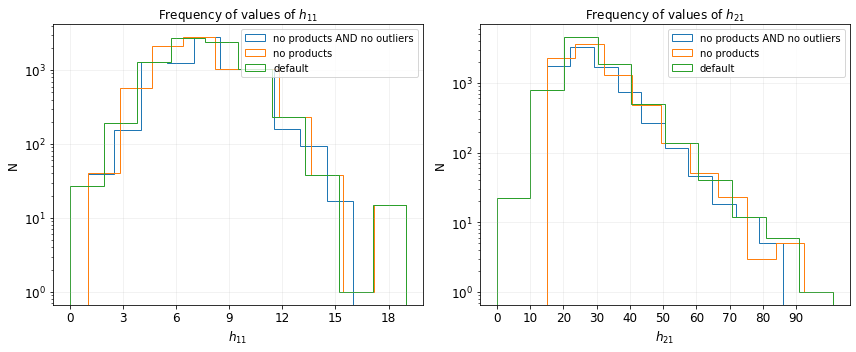

In [9]:
fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

count_plot(plot[0], df_noprod_noout['h11'], title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='no products AND no outliers', ylog=True, binstep=3)
count_plot(plot[0], df_noprod['h11'],       title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='no products',                 ylog=True, binstep=3)
count_plot(plot[0], df['h11'],              title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='default',                     ylog=True, binstep=3)

count_plot(plot[1], df_noprod_noout['h21'], title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='no products AND no outliers', ylog=True, binstep=10)
count_plot(plot[1], df_noprod['h21'],       title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='no products',                 ylog=True, binstep=10)
count_plot(plot[1], df['h21'],              title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='default',                     ylog=True, binstep=10)

save_fig('h11_h21_occurrencies_original')
plt.show()
plt.close(fig)

We then show the occurrencies of $h_{11}$ and $h_{21}$ with respect to a few features (scalars):

  Saving ./img/h11_h21_distributions-comparison_original.png...
  Saved ./img/h11_h21_distributions-comparison_original.png!


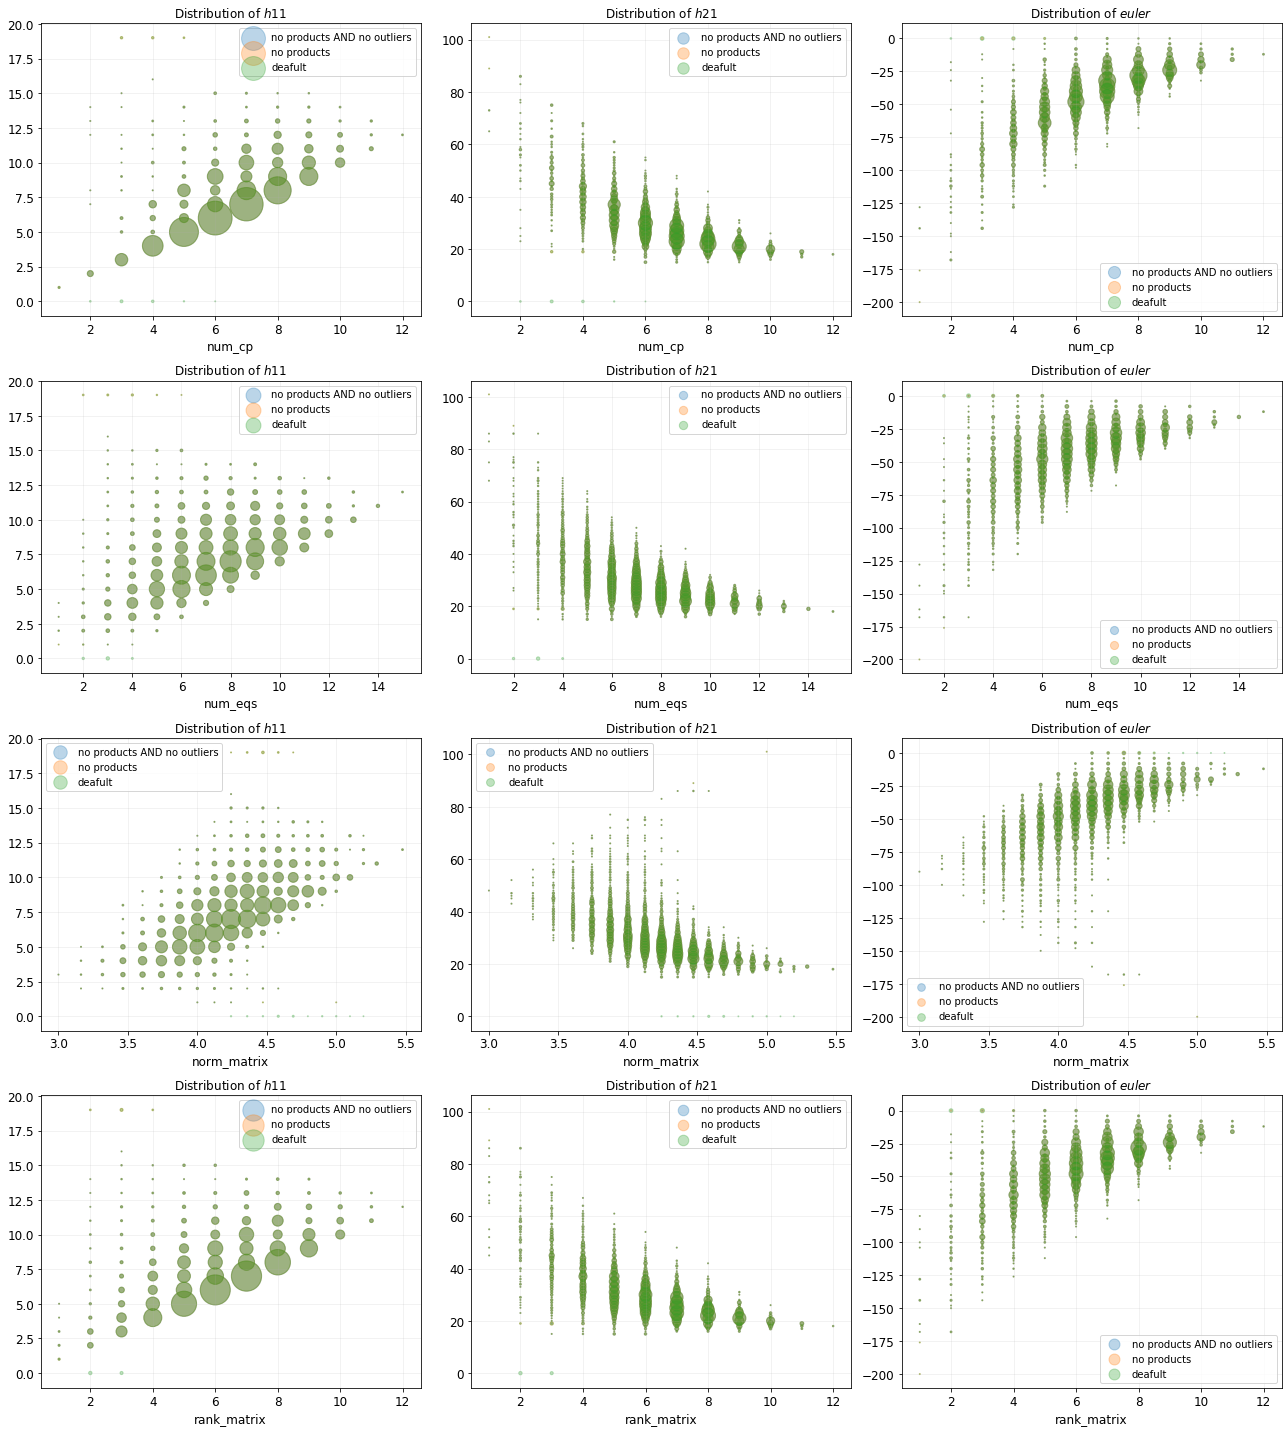

  Saving ./img/h11_h21_distributions_original.png...
  Saved ./img/h11_h21_distributions_original.png!


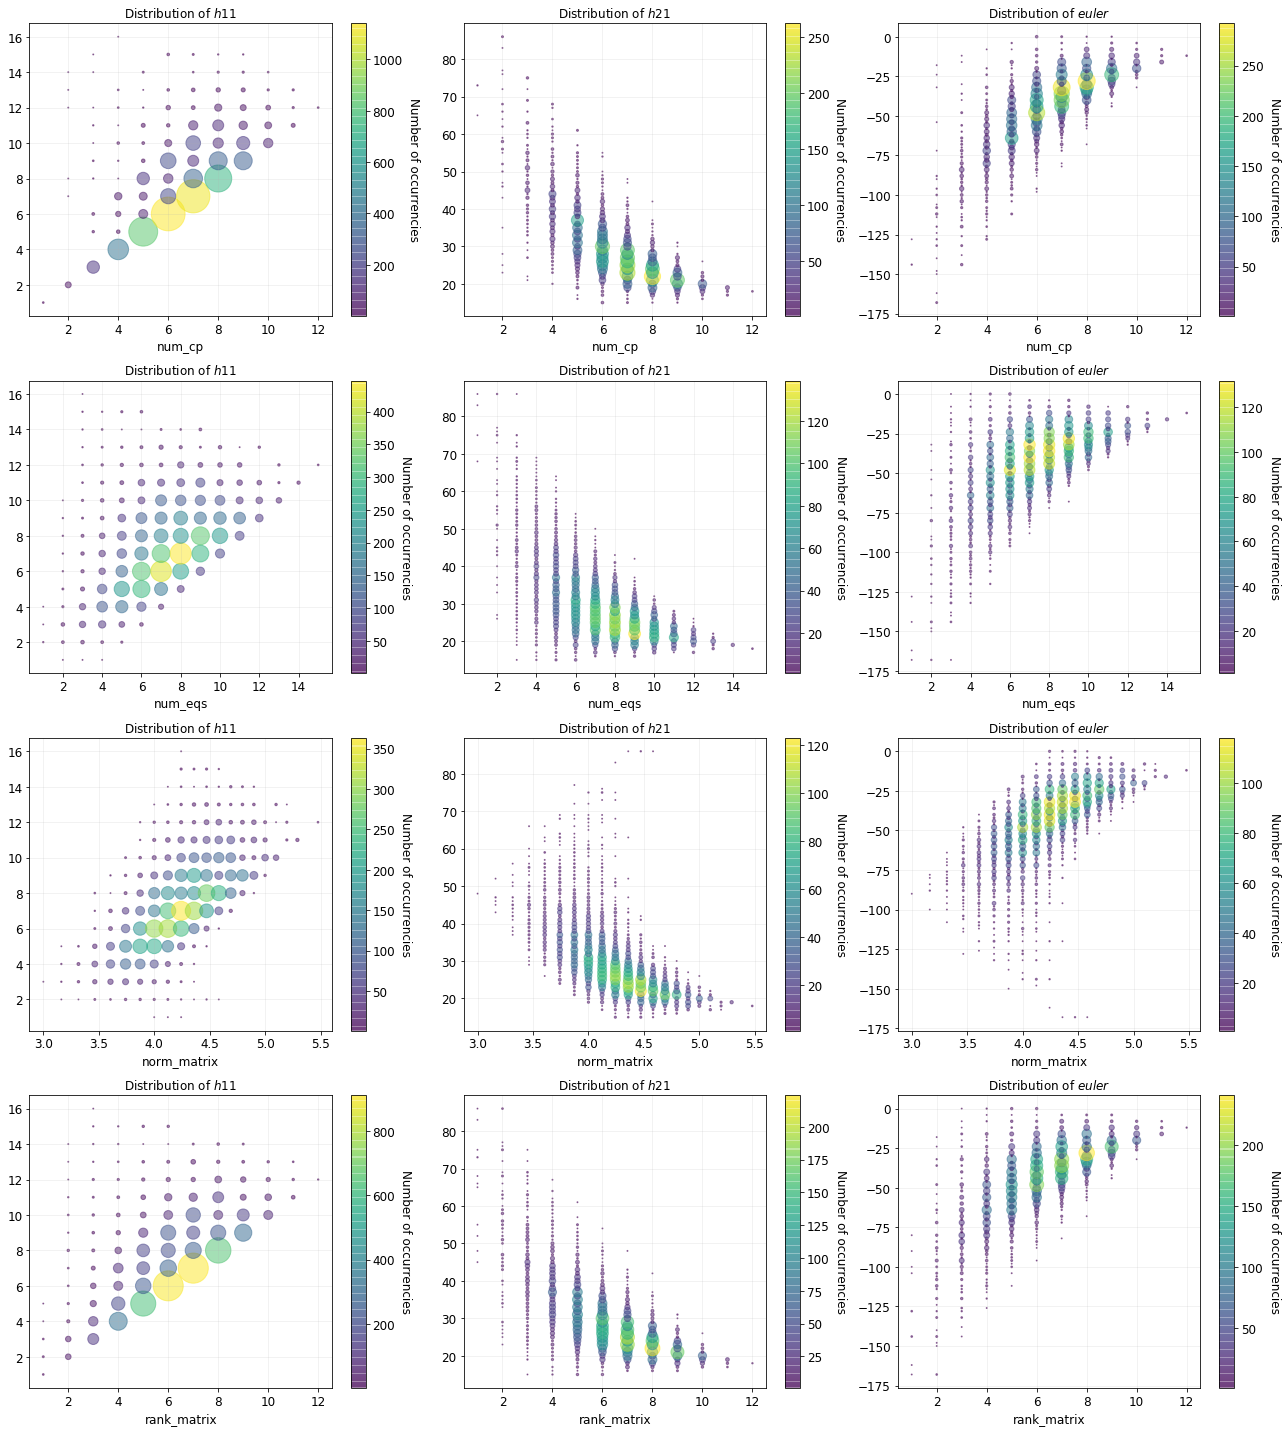

In [10]:
scat_feat = [ 'num_cp', 'num_eqs', 'norm_matrix', 'rank_matrix' ]
scat_labs = [ 'h11', 'h21', 'euler' ]

fig, plot = plt.subplots(len(scat_feat), len(scat_labs), figsize=(6*len(scat_labs),5*len(scat_feat)))
fig.tight_layout()

for n in range(len(scat_feat)):
    for m in range(len(scat_labs)):
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod_noout, scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='no products AND no outliers', alpha=0.3)
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod,       scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='no products',                 alpha=0.3)
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df,              scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='deafult',                     alpha=0.3)

save_fig('h11_h21_distributions-comparison_original')
plt.show()
plt.close(fig)

fig, plot = plt.subplots(len(scat_feat), len(scat_labs), figsize=(6*len(scat_labs),5*len(scat_feat)))
fig.tight_layout()

for n in range(len(scat_feat)):
    for m in range(len(scat_labs)):
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod_noout, scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=True, colour_label='Number of occurrencies', alpha=0.5)

save_fig('h11_h21_distributions_original')
plt.show()
plt.close(fig)

### Feature Selection

We select only the usable columns and divide the data into labels and features:

In [11]:
features_to_drop = list(df_noprod_noout.filter(regex='min_|max_|median_|mean_').columns) + ['c2', 'redun', 'isprod', 'favour', 'size']
df               = df_noprod_noout.drop(labels=features_to_drop, axis=1)

labels      = ['h11', 'h21', 'euler']
df_features = df.drop(labels=labels, axis=1)
df_labels   = df[labels]

We then divide scalar, vector and tensor features in order to process them separately:

In [12]:
scalar_features = list(df_features.select_dtypes(include=['int8', 'int64', 'float64']).columns)
vector_features = list(df_features.drop(labels='matrix', axis=1).select_dtypes(include=['object']).columns)
tensor_features = list(df_features.drop(labels=vector_features, axis=1).select_dtypes(include=['object']).columns)

We then extract the sparse tensors and vectors from their dense definitions:

In [13]:
for feature in vector_features:
    df_features[feature] = ExtractTensor(flatten=False).fit_transform(df_features[feature])
for feature in tensor_features:
    df_features[feature] = ExtractTensor(flatten=False).fit_transform(df_features[feature])
    
df_features = df_features[scalar_features + vector_features + tensor_features] # this is a simple reorder of the dataframe

We can then mark the dataframe as "production-ready" and save it to file:

In [14]:
DB_PROD_NAME = DB_NAME + '_features_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df_features.to_hdf(DB_PROD_PATH, key='df')

DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df_labels.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs', 'dim_h0_amb',
       'matrix'],
      dtype='object')]

  encoding=encoding,


## Feature Engineering

We now consider the further engineering of the feature space: we consider Kmeans clustering and PCA on the matrix components and then look at the importance of the features in order to select only the relevant ones.

### Clustering analysis

Consider the clustering analysis on the matrix components in order to gain more insight on the relevance of the data:

In [15]:
DB_PROD_NAME = DB_NAME + '_features_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

Now extract the flattened matrix components:

In [16]:
df['matrix_flat'] = ExtractTensor(flatten=True).fit_transform(df['matrix'])

Then compute the labels of the clustering algorithm with $n$ clusters for $n \in \lbrace 2, ... \rbrace$:

In [17]:
cluster_range = range(2,20)
kmeans_labels = np.empty([df['matrix_flat'].shape[0], len(cluster_range)], dtype='int32')

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=RAND, n_jobs=-1)
    kmeans.fit_transform(np.stack(df['matrix_flat']))
    kmeans_labels[:,n-min(cluster_range)] = kmeans.labels_

df['clustering'] = list(kmeans_labels)

df = df[scalar_features + ['clustering'] + vector_features + tensor_features] # simple reorder of the dataframe

Then save the dataframe to file (we start to create an "analysis-ready" file which will be overwritten every time we add features or we select others):

In [18]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['clustering', 'dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs',
       'dim_h0_amb', 'matrix'],
      dtype='object')]

  encoding=encoding,


### PCA Analysis

We then move to the PCA on the matrix in order to study the relevance of its components. We also plot the distribution of $h_{11}$ and $h_{21}$ on the 2 principal components of the matrix.

In [19]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

Now extract the flattened matrix components:

In [20]:
df['matrix_flat'] = ExtractTensor(flatten=True).fit_transform(df['matrix'])

Then apply PCA with 2 components (keep it separate, since it is not really useful for the analysis) and 99% of the variance:

In [21]:
pca2             = PCA(n_components=2, random_state=RAND)
matrix_pca_2     = pca2.fit_transform(np.stack(df['matrix_flat']))
matrix_pca_2_var = pca2.explained_variance_ratio_
print('Variance for 2 components PCA: {:.3f}% for the first component, {:.3f}% for the second component'.format(matrix_pca_2_var[0]*100, matrix_pca_2_var[1]*100))

df['matrix_pca99'] = list(PCA(n_components=0.99, random_state=RAND).fit_transform(np.stack(df['matrix_flat'])))
print('No. of components of the PCA matrix with 99% variance preserved: {:d}'.format(df['matrix_pca99'].apply(np.shape).unique()[0][0]))

df = df[scalar_features + ['clustering'] + vector_features + tensor_features + ['matrix_pca99']] # simple reorder of the dataframe

Variance for 2 components PCA: 9.087% for the first component, 5.594% for the second component
No. of components of the PCA matrix with 99% variance preserved: 81


Then save the dataframe to file:

In [22]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['clustering', 'dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs',
       'dim_h0_amb', 'matrix', 'matrix_pca99'],
      dtype='object')]

  encoding=encoding,


Then plot the distribution of $h_{11}$ and $h_{21}$ with respect to the 2 principal directions of the PCA:

  Saving ./img/h11_h21_pca-distribution_original.png...
  Saved ./img/h11_h21_pca-distribution_original.png!


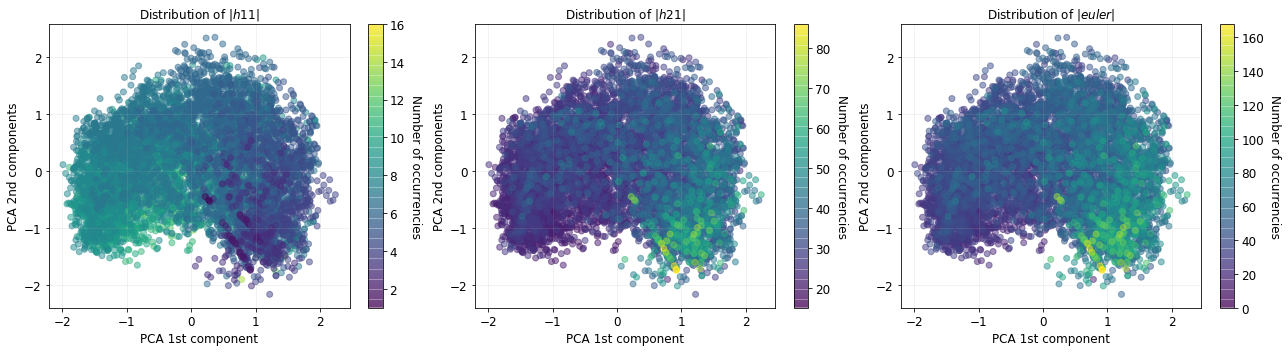

In [23]:
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

labels = df_labels.columns

fig, plot = plt.subplots(1, len(labels), figsize=(6*len(labels),5))
fig.tight_layout()

for n in range(len(labels)):
    scatter_plot(plot[n], [ matrix_pca_2[:,0], matrix_pca_2[:,1], np.abs(df_labels[labels[n]]) ], title='Distribution of $|{}|$'.format(labels[n]), xlabel='PCA 1st component', ylabel='PCA 2nd components', size=False, colour=True, colour_label='Number of occurrencies', alpha=0.5)

save_fig('h11_h21_pca-distribution_original')
plt.show()
plt.close(fig)

### Feature Importances (Random Forest/Decision Tree)

We now use a Random Forest (or simple Decision Tree) to evaluate the importance of the features used in the dataframe. We then choose whether to drop some of them and which one to take into more consideration. Since this is mostly a qualitative analysis, we operate on the entire set and withouth a deep optimization.

In [40]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the features database!')
    
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the labels database!')

Create a matrix to hold all the features to be fed to the Decision Tree:

In [65]:
dtree_features = df[scalar_features].values
for feature in ['clustering'] + vector_features:
    dtree_features = np.c_[dtree_features, ExtractTensor(flatten=True).fit_transform(df[feature])]
for feature in tensor_features + ['matrix_pca99']:
    dtree_features = np.c_[dtree_features, ExtractTensor(flatten=True).fit_transform(df[feature])]

Then create the Decision Tree and train it:

In [113]:
params = { 'criterion':    'mse',
           'random_state': RAND
         }

dtree_h11 = DecisionTreeRegressor(**params)
print('Fitting for h_11...')
dtree_h11.fit(dtree_features, df_labels['h11'])

dtree_h21 = DecisionTreeRegressor(**params)
print('Fitting for h_21...')
dtree_h21.fit(dtree_features, df_labels['h21'])

# check accuracy just "for fun"
print('Accuracy for h_11: {:.3f}%'.format(accuracy_score(df_labels['h11'].values, dtree_h11.predict(dtree_features))*100))
print('Accuracy for h_21: {:.3f}%'.format(accuracy_score(df_labels['h21'].values, dtree_h21.predict(dtree_features))*100))

Fitting for h_11...
Fitting for h_21...
Accuracy for h_11: 100.000%
Accuracy for h_21: 100.000%


We then plot the feature importances together with their labels:

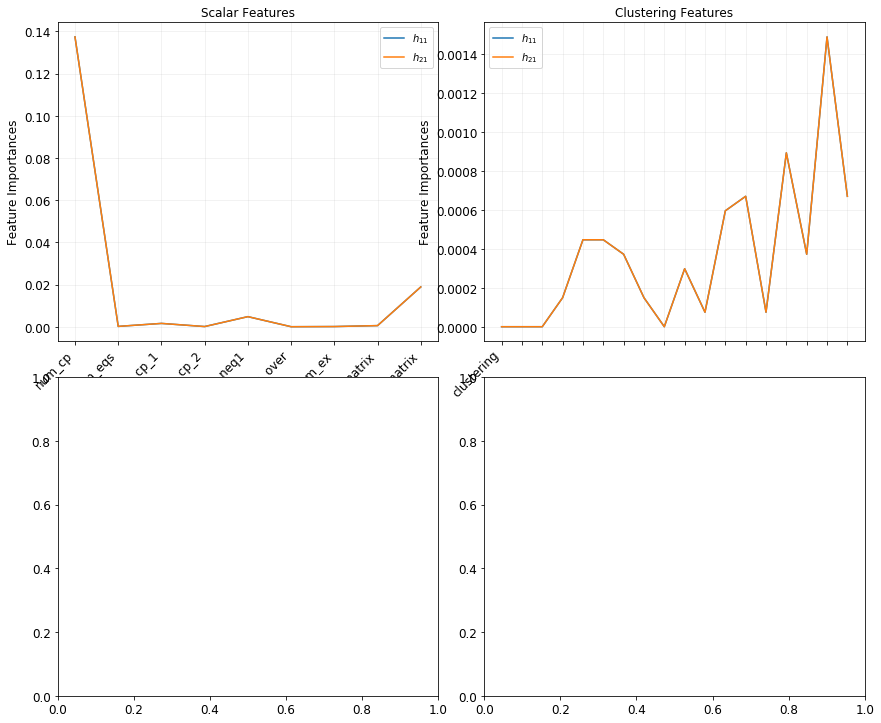

In [112]:
feature_extended_labels = []
for column in df:
    length = np.prod(df[column].values[0].shape).astype(int)
    feature_extended_labels.append(column)
    for n in range(length-1):
        feature_extended_labels.append('')

importances_h11 = list(zip(feature_extended_labels, dtree_h11.feature_importances_))
importances_h21 = list(zip(feature_extended_labels, dtree_h11.feature_importances_))

fig, plot = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

label_plot(plot[0,0], importances_h11[0:9], title='Scalar Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[0,0], importances_h21[0:9], title='Scalar Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot(plot[0,1], importances_h11[9:27], title='Clustering Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[0,1], importances_h21[9:27], title='Clustering Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot

plt.show()
plt.close(fig)

In [81]:
df.columns

Index(['num_cp', 'num_eqs', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over',
       'num_ex', 'rank_matrix', 'norm_matrix', 'clustering', 'dim_cp',
       'num_dim_cp', 'deg_eqs', 'num_deg_eqs', 'dim_h0_amb', 'matrix',
       'matrix_pca99'],
      dtype='object')

In [110]:
importances_h11[9:]

[('clustering', 0.0),
 ('', 0.0),
 ('', 0.0),
 ('', 0.00014900908955446283),
 ('', 0.0004470272686633884),
 ('', 0.0004470272686633884),
 ('', 0.00037252272388615704),
 ('', 0.00014900908955446283),
 ('', 0.0),
 ('', 0.00029801817910892565),
 ('', 7.450454477723141e-05),
 ('', 0.0005960363582178513),
 ('', 0.0006705409029950806),
 ('', 7.450454477723141e-05),
 ('', 0.0008940545373267769),
 ('', 0.00037252272388615704),
 ('', 0.0014900908955446282),
 ('', 0.0006705409029950826),
 ('dim_cp', 0.0),
 ('', 0.0),
 ('', 0.0032781999701981816),
 ('', 0.012442258977797644),
 ('', 0.0005215318134406199),
 ('', 0.09774996274772761),
 ('', 0.27507077931753837),
 ('', 0.0),
 ('', 0.0),
 ('', 0.003054686335866488),
 ('', 0.0),
 ('', 0.0),
 ('num_dim_cp', 0.002533154522425868),
 ('', 0.0002235136343316942),
 ('', 7.450454477723126e-05),
 ('', 0.0),
 ('', 0.0),
 ('', 0.0),
 ('', 0.0),
 ('deg_eqs', 0.0),
 ('', 0.0),
 ('', 0.0002235136343316942),
 ('', 7.450454477723141e-05),
 ('', 0.0008195499925495454

In [91]:
np.sum(importances_h11[1,0:27])

TypeError: list indices must be integers or slices, not tuple

In [100]:
np.sum([ f[1] for f in importances_h11[9:27] ])

0.0067054090299508255